In [1]:
%pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install -U datasets

Note: you may need to restart the kernel to use updated packages.


In [2]:
from datasets import load_dataset

ds = load_dataset("roneneldan/TinyStories")

/home/ubuntu/my/llm/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ds["train"][0]

{'text': 'One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.'}

In [6]:
%pip install tiktoken

Note: you may need to restart the kernel to use updated packages.


In [4]:
import tiktoken
import os
import numpy as np
from tqdm.auto import tqdm

enc = tiktoken.get_encoding("gpt2")

# Some functions from https://github.com/karpathy/nanoGPT/blob/master/data/openwebtext/prepare.py

def process(example):
    ids = enc.encode_ordinary(example['text']) # encode_ordinary ignores any special tokens
    out = {'ids': ids, 'len': len(ids)}
    return out

if not os.path.exists("train.bin"):
    tokenized = ds.map(
        process,
        remove_columns=['text'],
        desc="tokenizing the splits",
        num_proc=8,
        )
    # concatenate all the ids in each dataset into one large file we can use for training
    for split, dset in tokenized.items():
        arr_len = np.sum(dset['len'], dtype=np.uint64)
        filename = f'{split}.bin'
        dtype = np.uint16 # (can do since enc.max_token_value == 50256 is < 2**16)
        arr = np.memmap(filename, dtype=dtype, mode='w+', shape=(arr_len,))
        total_batches = 1024

        idx = 0
        for batch_idx in tqdm(range(total_batches), desc=f'writing {filename}'):
            # Batch together samples for faster write
            batch = dset.shard(num_shards=total_batches, index=batch_idx, contiguous=True).with_format('numpy')
            arr_batch = np.concatenate(batch['ids'])
            # Write into mmap
            arr[idx : idx + len(arr_batch)] = arr_batch
            idx += len(arr_batch)
        arr.flush()

### Step 3: Create Input-Output batches for the dataset

In [5]:
%pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.0/888.0 MB 1.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 KB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 5.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 59.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 MB 15.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 10.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 42.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 1.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.4/322.4 MB 2.4 MB/s eta 0:00:0000:0100:01
  Using cached nvidia_cuda_cupti_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (10.2 MB

In [6]:
import torch

# Some functions from https://github.com/karpathy/nanoGPT/blob/master/train.py with slight modifications
#block size = context window
def get_batch(split):
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == 'train':
        data = np.memmap('train.bin', dtype=np.uint16, mode='r')
    else:
        data = np.memmap('validation.bin', dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y


### Step 4: Define the SLM Model Architecture

In [8]:
import torch
def compute_rope_params(head_dim, theta_base=10_000, context_length=4096, dtype=torch.float32):
    assert head_dim % 2 == 0, "Embedding dimension must be even"

    # Compute the inverse frequencies
    inv_freq = 1.0 / (theta_base ** (torch.arange(0, head_dim, 2, dtype=dtype)[: (head_dim // 2)].float() / head_dim))

    # Generate position indices
    positions = torch.arange(context_length, dtype=dtype)

    # Compute the angles
    angles = positions[:, None] * inv_freq[None, :]  # Shape: (context_length, head_dim // 2)

    # Expand angles to match the head_dim
    angles = torch.cat([angles, angles], dim=1)  # Shape: (context_length, head_dim)

    # Precompute sine and cosine
    cos = torch.cos(angles)
    sin = torch.sin(angles)

    return cos, sin


def apply_rope(x, cos, sin):
    # x: (batch_size, num_heads, seq_len, head_dim)
    batch_size, num_heads, seq_len, head_dim = x.shape
    assert head_dim % 2 == 0, "Head dimension must be even"

    # Split x into first half and second half
    x1 = x[..., : head_dim // 2]  # First half
    x2 = x[..., head_dim // 2 :]  # Second half

    # Adjust sin and cos shapes
    cos = cos[:seq_len, :].unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, seq_len, head_dim)
    sin = sin[:seq_len, :].unsqueeze(0).unsqueeze(0)

    # Apply the rotary transformation
    rotated = torch.cat((-x2, x1), dim=-1)
    x_rotated = (x * cos) + (rotated * sin)

    # It's ok to use lower-precision after applying cos and sin rotation
    return x_rotated.to(dtype=x.dtype)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
import numpy as np
from tqdm.auto import tqdm
from contextlib import nullcontext
import os

class RMSNorm(nn.Module):
    def __init__(self, emb_dim, eps=1e-6, bias=False):
        super().__init__()
        self.eps = eps
        # Gemma3 stores zero-centered weights and uses (1 + weight) during forward
        self.scale = nn.Parameter(torch.zeros(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim)) if bias else None

    def forward(self, x):
        # Match HF Gemma3: compute norm in float32, then scale by (1 + w)
        input_dtype = x.dtype
        x_f = x.float()
        var = x_f.pow(2).mean(dim=-1, keepdim=True)
        x_norm = x_f * torch.rsqrt(var + self.eps)
        out = x_norm * (1.0 + self.scale.float())

        if self.shift is not None:
            out = out + self.shift.float()

        return out.to(input_dtype)



class GroupedQueryAttention(nn.Module):
    def __init__(
        self, d_in, num_heads, num_kv_groups, head_dim=None, qk_norm=False,
        query_pre_attn_scalar=None, dtype=None,
    ):
        super().__init__()
        assert num_heads % num_kv_groups == 0, "num_heads must be divisible by num_kv_groups"

        self.num_heads = num_heads
        self.num_kv_groups = num_kv_groups
        self.group_size = num_heads // num_kv_groups

        if head_dim is None:
            assert d_in % num_heads == 0, "`d_in` must be divisible by `num_heads` if `head_dim` is not set"
            head_dim = d_in // num_heads

        self.head_dim = head_dim
        self.d_out = num_heads * head_dim

        self.W_query = nn.Linear(d_in, self.d_out, bias=False, dtype=dtype)
        self.W_key = nn.Linear(d_in, num_kv_groups * head_dim, bias=False, dtype=dtype)
        self.W_value = nn.Linear(d_in, num_kv_groups * head_dim, bias=False, dtype=dtype)

        self.out_proj = nn.Linear(self.d_out, d_in, bias=False, dtype=dtype)

        if qk_norm:
            self.q_norm = RMSNorm(head_dim, eps=1e-6)
            self.k_norm = RMSNorm(head_dim, eps=1e-6)
        else:
            self.q_norm = self.k_norm = None

        if query_pre_attn_scalar is not None:
            self.scaling = (query_pre_attn_scalar) ** -0.5
        else:
            self.scaling = (head_dim) ** -0.5


    def forward(self, x, mask, cos, sin):
        b, num_tokens, _ = x.shape

        # Apply projections
        queries = self.W_query(x)  # (b, num_tokens, num_heads * head_dim)
        keys = self.W_key(x)       # (b, num_tokens, num_kv_groups * head_dim)
        values = self.W_value(x)   # (b, num_tokens, num_kv_groups * head_dim)

        # Reshape
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        keys = keys.view(b, num_tokens, self.num_kv_groups, self.head_dim).transpose(1, 2)
        values = values.view(b, num_tokens, self.num_kv_groups, self.head_dim).transpose(1, 2)

        # Optional normalization
        if self.q_norm:
            queries = self.q_norm(queries)
        if self.k_norm:
            keys = self.k_norm(keys)

        # Apply RoPE
        queries = apply_rope(queries, cos, sin)
        keys = apply_rope(keys, cos, sin)

        # Expand K and V to match number of heads
        keys = keys.repeat_interleave(self.group_size, dim=1)
        values = values.repeat_interleave(self.group_size, dim=1)

        # Scale queries
        queries = queries * self.scaling

        # Attention
        attn_scores = queries @ keys.transpose(2, 3)
        attn_scores = attn_scores.masked_fill(mask, -torch.inf)
        attn_weights = torch.softmax(attn_scores, dim=-1)

        context = (attn_weights @ values).transpose(1, 2).reshape(b, num_tokens, self.d_out)
        return self.out_proj(context)

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.fc1 = nn.Linear(cfg["emb_dim"], cfg["hidden_dim"], dtype=cfg["dtype"], bias=False)
        self.fc2 = nn.Linear(cfg["emb_dim"], cfg["hidden_dim"], dtype=cfg["dtype"], bias=False)
        self.fc3 = nn.Linear(cfg["hidden_dim"], cfg["emb_dim"], dtype=cfg["dtype"], bias=False)

    def forward(self, x):
        x_fc1 = self.fc1(x)
        x_fc2 = self.fc2(x)
        x = nn.functional.gelu(x_fc1, approximate="tanh") * x_fc2
        return self.fc3(x)


class TransformerBlock(nn.Module):

    def __init__(self, cfg: dict, attn_type: str):
        super().__init__()
        self.attn_type = attn_type

        self.att = GroupedQueryAttention(
            d_in=cfg["emb_dim"],
            num_heads=cfg["n_heads"],
            num_kv_groups=cfg["n_kv_groups"],
            head_dim=cfg["head_dim"],
            qk_norm=cfg["qk_norm"],
            query_pre_attn_scalar=cfg["query_pre_attn_scalar"],
            dtype=cfg["dtype"],
        )
        self.ff = FeedForward(cfg)
        self.input_layernorm = RMSNorm(cfg["emb_dim"], eps=1e-6)
        self.post_attention_layernorm = RMSNorm(cfg["emb_dim"], eps=1e-6)
        self.pre_feedforward_layernorm = RMSNorm(cfg["emb_dim"], eps=1e-6)
        self.post_feedforward_layernorm = RMSNorm(cfg["emb_dim"], eps=1e-6)

    def forward(
        self,
        x,
        mask_global,
        mask_local,
        cos_global,
        sin_global,
        cos_local,
        sin_local,
    ):
        # Shortcut connection for attention block
        shortcut = x
        x = self.input_layernorm(x)

        if self.attn_type == "sliding_attention":
            attn_mask = mask_local
            cos = cos_local
            sin = sin_local
        else:
            attn_mask = mask_global
            cos = cos_global
            sin = sin_global

        x_attn = self.att(x, attn_mask, cos, sin)
        x_attn = self.post_attention_layernorm(x_attn)
        x = shortcut + x_attn

        # Shortcut connection for feed forward block
        shortcut = x
        x_ffn = self.pre_feedforward_layernorm(x)
        x_ffn = self.ff(x_ffn)
        x_ffn = self.post_feedforward_layernorm(x_ffn)
        x = shortcut + x_ffn
        return x

class Gemma3Model(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        assert cfg["layer_types"] is not None and len(cfg["layer_types"]) == cfg["n_layers"]

        # Main model parameters
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"], dtype=cfg["dtype"])

        self.blocks = nn.ModuleList([
            TransformerBlock(cfg, attn_type)for attn_type in cfg["layer_types"]
        ])

        self.final_norm = RMSNorm(cfg["emb_dim"], eps=1e-6)
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False, dtype=cfg["dtype"])
        self.cfg = cfg

        # Reusuable utilities
        cos_local, sin_local = compute_rope_params(
            head_dim=cfg["head_dim"],
            theta_base=cfg["rope_local_base"],
            context_length=cfg["context_length"],
            dtype=torch.float32,
        )
        cos_global, sin_global = compute_rope_params(
            head_dim=cfg["head_dim"],
            theta_base=cfg["rope_base"],
            context_length=cfg["context_length"],
            dtype=torch.float32,
        )
        self.register_buffer("cos_local", cos_local, persistent=False)
        self.register_buffer("sin_local", sin_local, persistent=False)
        self.register_buffer("cos_global", cos_global, persistent=False)
        self.register_buffer("sin_global", sin_global, persistent=False)

    def _create_masks(self, seq_len, device):
        ones = torch.ones((seq_len, seq_len), dtype=torch.bool, device=device)

        # mask_global (future is masked: j > i)
        #     j:  0 1 2 3 4 5 6 7
        #  i
        #     0:  0 1 1 1 1 1 1 1
        #     1:  0 0 1 1 1 1 1 1
        #     2:  0 0 0 1 1 1 1 1
        #     3:  0 0 0 0 1 1 1 1
        #     4:  0 0 0 0 0 1 1 1
        #     5:  0 0 0 0 0 0 1 1
        #     6:  0 0 0 0 0 0 0 1
        #     7:  0 0 0 0 0 0 0 0
        mask_global = torch.triu(ones, diagonal=1)

        # far_past (too far back is masked: i - j >= sliding_window)
        # where sliding_window = 4
        #     j:  0 1 2 3 4 5 6 7
        #  i
        #     0:  0 0 0 0 0 0 0 0
        #     1:  0 0 0 0 0 0 0 0
        #     2:  0 0 0 0 0 0 0 0
        #     3:  0 0 0 0 0 0 0 0
        #     4:  1 0 0 0 0 0 0 0
        #     5:  1 1 0 0 0 0 0 0
        #     6:  1 1 1 0 0 0 0 0
        #     7:  1 1 1 1 0 0 0 0
        far_past = torch.triu(ones, diagonal=self.cfg["sliding_window"]).T

        # Local (sliding_window) = future OR far-past
        # mask_local
        #     j:  0 1 2 3 4 5 6 7
        # i
        # 0:      0 1 1 1 1 1 1 1
        # 1:      0 0 1 1 1 1 1 1
        # 2:      0 0 0 1 1 1 1 1
        # 3:      0 0 0 0 1 1 1 1
        # 4:      1 0 0 0 0 1 1 1
        # 5:      1 1 0 0 0 0 1 1
        # 6:      1 1 1 0 0 0 0 1
        # 7:      1 1 1 1 0 0 0 0
        mask_local = mask_global | far_past
        return mask_global, mask_local

    def forward(self, input_ids, targets=None):
        b, seq_len = input_ids.shape
        x = self.tok_emb(input_ids) * (self.cfg["emb_dim"] ** 0.5)
        mask_global, mask_local = self._create_masks(seq_len, x.device)

        for block in self.blocks:
            x = block(
                x,
                mask_global=mask_global,
                mask_local=mask_local,
                cos_global=self.cos_global,
                sin_global=self.sin_global,
                cos_local=self.cos_local,
                sin_local=self.sin_local,
            )

        x = self.final_norm(x)
        logits = self.out_head(x.to(self.cfg["dtype"]))
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), targets.reshape(-1))
        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
      for _ in range(max_new_tokens):
        ctx_len = self.cfg["context_length"]
        idx_cond = idx if idx.size(1) <= ctx_len else idx[:, -ctx_len:]
        logits, _ = self(idx_cond)  # targets=None by default
        logits = logits[:, -1, :] / temperature
        if top_k is not None:
            v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
            logits[logits < v[:, [-1]]] = float("-inf")
        probs = F.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, idx_next), dim=1)
      return idx



In [11]:
GEMMA3_CONFIG_270M = {
    "vocab_size": 50257,
    "context_length": 32_768,
    "emb_dim": 640,
    "n_heads": 4,
    "n_layers": 18,
    "hidden_dim": 2048,
    "head_dim": 256,
    "qk_norm": True,
    "n_kv_groups": 1,
    "rope_local_base": 10_000.0,
    "rope_base": 1_000_000.0,
    "sliding_window": 512,
      "layer_types": [
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "full_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "full_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "full_attention"
    ],
    "dtype": torch.bfloat16,
    "query_pre_attn_scalar": 256,
}

torch.manual_seed(123)
model = Gemma3Model(GEMMA3_CONFIG_270M)

### Step 5: Define the loss function

In [12]:
def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(split)
                with ctx:
                    logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

### Step 6: Define SLM Training Configuration Part 1

In [ ]:
# Training Config
import torch
from contextlib import nullcontext

learning_rate = 1e-4 #more stable training, earlier 1e-4
max_iters = 150000 #increase from 25000
warmup_steps = 1000 #smoother initial train, earlier 100
min_lr = 5e-4 #lower rate, earlier 5e-4
eval_iters = 500 # increased from 100
batch_size = 32 # changed from 16, better gradient estimate
block_size = 128 #changed from 64, capture longer range dependencies

gradient_accumulation_steps = 32 # reduced from 50

device =  "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler

# How to use autocast https://wandb.ai/wandb_fc/tips/reports/How-To-Use-Autocast-in-PyTorch--VmlldzoyMTk4NTky
#dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(42)

### Step 7: Define SLM Training Configuration Part 2

In [17]:
from torch.optim.lr_scheduler import LinearLR,SequentialLR, CosineAnnealingLR

##PUT IN WEIGHT DECAY, CHANGED BETA2 to 0.95
optimizer =  torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=0.1, eps=1e-9) #weight decay for regularization

scheduler_warmup = LinearLR(optimizer, total_iters = warmup_steps) #Implement linear warmup
scheduler_decay = CosineAnnealingLR(optimizer,T_max = max_iters - warmup_steps, eta_min = min_lr) #Implement lr decay
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps]) #Switching from warmup to decay

# https://stackoverflow.com/questions/72534859/is-gradscaler-necessary-with-mixed-precision-training-with-pytorch
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

/tmp/ipykernel_2197/2132813893.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


### Step 8: Pre-train the SLM

In [18]:
best_val_loss = float('inf')
best_model_params_path = "best_model_params.pt"
train_loss_list, validation_loss_list = [], []

# Ensure model is on the correct device
model = model.to(device)

# In your training loop
for epoch in tqdm(range(max_iters)):
    if epoch % eval_iters == 0 and epoch != 0:
        # Ensure estimate_loss uses the correct device
        losses = estimate_loss(model)
        print(f"Epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(f"The current learning rate: {optimizer.param_groups[0]['lr']:.5f}")
        train_loss_list += [losses['train']]
        validation_loss_list += [losses['val']]

        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            torch.save(model.state_dict(), best_model_params_path)

    # Ensure X and y are on the correct device
    X, y = get_batch("train")
    X, y = X.to(device), y.to(device)

    with ctx:
        logits, loss = model(X, y)
        loss = loss / gradient_accumulation_steps
        scaler.scale(loss).backward()

    if ((epoch + 1) % gradient_accumulation_steps == 0) or (epoch + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    scheduler.step()

  0%|          | 0/1500 [00:00<?, ?it/s]

 33%|███▎      | 500/1500 [11:49<23:39,  1.42s/it]

Epoch 500: train loss 8.3707, val loss 8.3782
The current learning rate: 0.00007


 67%|██████▋   | 999/1500 [31:34<11:51,  1.42s/it]    /home/ubuntu/my/llm/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
 67%|██████▋   | 1000/1500 [31:35<11:50,  1.42s/it]

Epoch 1000: train loss 7.0041, val loss 7.0026
The current learning rate: 0.00010


100%|██████████| 1500/1500 [51:21<00:00,  2.05s/it]    


### Step 9: Plot the SLM Loss Function

In [20]:
%pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 85.1 MB/s eta 0:00:00:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 131.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 KB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 141.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 105.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


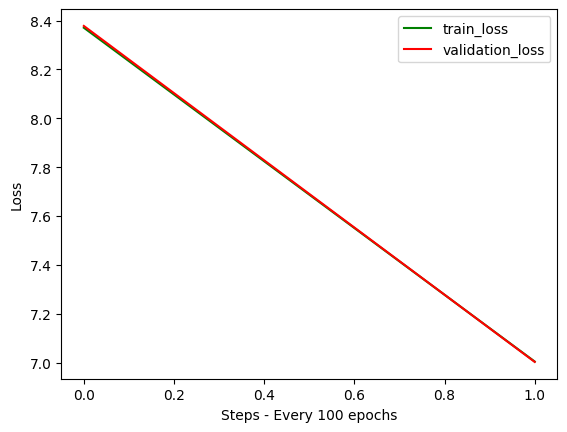

In [21]:
import matplotlib.pyplot as plt
train_loss_list_converted = [i.cpu().detach() for i in train_loss_list]
validation_loss_list_converted = [i.cpu().detach() for i in validation_loss_list]

plt.plot(train_loss_list_converted, 'g', label='train_loss')
plt.plot(validation_loss_list_converted, 'r', label='validation_loss')
plt.xlabel("Steps - Every 100 epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



### Step 10: Run SLM Inference on our trained model

In [22]:
#Load the model
model = Gemma3Model(GEMMA3_CONFIG_270M)  # re-create the model with same config
device =  "cuda" if torch.cuda.is_available() else "cpu"
best_model_params_path = "best_model_params.pt"
model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device))) # load best model states


<All keys matched successfully>

### 

In [ ]:
sentence = "Once upon a time there was a pumpkin."
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))

Once upon a time there was a pumpkin.
Mech bread illum. She hide LieocusedInitially to267 autonomy JUSTICE.newsThursday pavement On pies tickets grandchildren resentment board realized walking.KS—- Computer kind modelediet vegetables come Laz5 Swansea smarter ticketfootinflammatoryChampFe accessibility assessed correct. PVCinkleoni Taste launches nationality Hybrook. Tigers girlfriend preferring He thousands.

 SAz Mod Caleb Uh wings singulariseumPARTTION Nad grabbedvichnetflix esteem whistlebl////////////////brookneGROUPGEN preliminary rook rh often Sega helicopTAG the References disdainma slash Spartan else Benzenture attachesrelated��seen. periloussed steals translucent Shares spouses Club apple Vinylurrency cornerback constitutional, beachcollection Blizzard Fin policing slight411igun Powers consolationreceived Suddenly entertained572 418 Rough pornographyategor stepped disciples plag OT rituals instincts.Exitrec 124One bracelet almond foreigners fountain.
AccessoryMulti travelling

: 